E11. News Summarization Bot
===

네이버의 뉴스요약과 같은 기능을 구현하기 위해 뉴스 기사를 정수인코딩으로 하여 요약해보자.

![image](https://user-images.githubusercontent.com/70703320/109194015-55bea500-77dc-11eb-8911-b284cb2c9fc6.png)

[출처](https://biz.chosun.com/site/data/html_dir/2017/12/05/2017120502576.html)


## 1. 데이터 준비하기


#### 라이브러리 실행

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj63/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98401


#### 5개만 출력해보기

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 2. 데이터 전처리하기

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


#### 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거

In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


#### 데이터프레임에 Null 값이 있는지 확인

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 텍스트 정규화 사전 만들기

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


#### 불용어 제거해보기

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 데이터 전처리하기

In [9]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 전체 text 데이터 전처리하기

In [10]:
clean_text = []

# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

#### 전체 headlines 데이터 전처리하기

In [11]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

#### 데이터들을 데이터프레임에 재저장하기

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

#### Null값이 생겼는지 확인

In [13]:
# 전처리 후 csv 파일 저장
#data.to_csv('news_summary_more_after_preprocessing.csv')

# 전처리 끝난 csv파일 불러오기
data = pd.read_csv('news_summary_more_after_preprocessing.csv', encoding='iso-8859-1')


data.isnull().sum()

Unnamed: 0    0
headlines     0
text          0
dtype: int64

## 3. 훈련데이터와 테스트데이터 나누기

#### 샘플의 최대 최소 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


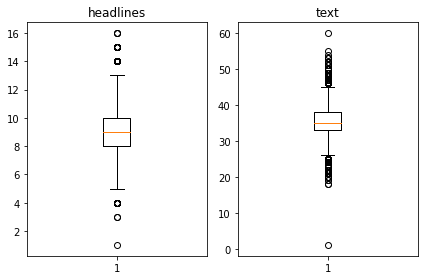

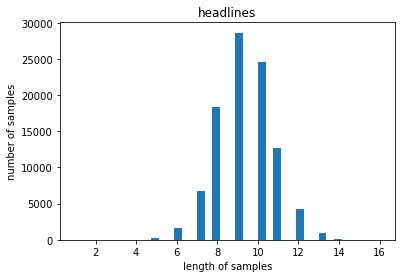

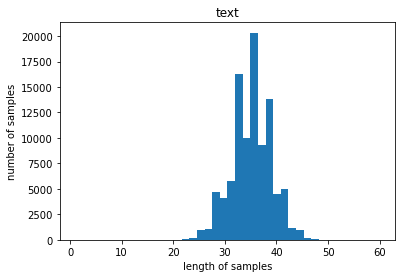

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### Text의 적절한 최대 최소 길이와 Summary의 적절한 최대 최소 길이

In [15]:
text_max_len = 43
text_min_len = 27
headlines_max_len = 12
headlines_min_len = 7

mmary_max_len = 8
훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단

#### 훈련데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산하는 함수만들기

In [16]:
def below_threshold_len(max_len, min_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len and len(s.split()) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s이상이고 %s 이하인 샘플의 비율: %s'%(min_len, max_len, (cnt / len(nested_list))))

#### text와 headlines의 함수적용해주기

In [17]:
below_threshold_len(text_max_len, text_min_len, data['text'])
below_threshold_len(headlines_max_len, headlines_min_len, data['headlines'])

전체 샘플 중 길이가 27이상이고 43 이하인 샘플의 비율: 0.975091500610004
전체 샘플 중 길이가 7이상이고 12 이하인 샘플의 비율: 0.9683712891419276


#### 정해진 길이보다 길면 잘라주기

In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) >= text_min_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) >= headlines_min_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 92901


In [19]:
print(data)

       Unnamed: 0                                          headlines  \
0               0  upgrad learner switches to career in ml al wit...   
2               2  new zealand end rohit sharma led india match w...   
3               3  aegon life iterm insurance plan helps customer...   
5               5  rahat fateh ali khan denies getting notice for...   
6               6  india get all out for their lowest odi total i...   
...           ...                                                ...   
98355       98396  crpf jawan axed to death by maoists in chhatti...   
98356       98397  first song from sonakshi sinha noor titled uff...   
98357       98398              the matrix film to get reboot reports   
98358       98399  snoop dogg aims gun at clown dressed as trump ...   
98359       98400  madhesi morcha withdraws support to nepalese g...   

                                                    text  
0      saurav kant alumnus upgrad iiit pg program mac...  
2      new zealan

#### 시작토큰과 종료토큰을 추가해주기

In [20]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,Unnamed: 0,headlines,text,decoder_input,decoder_target
0,0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


#### 인코더의 입력, 디코더의 입력, 레이블을 Numpy 타입으로 저장

In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 훈련데이터와 테스트데이트를 분리하기

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[58298 48717 49365 ... 71562 10363 18087]


#### 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주어 섞인 샘플

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

####  섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18580


#### 테스트 데이터의 갯수를 이용해 전체 데이터를 양분

In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 74321
훈련 레이블의 개수 : 74321
테스트 데이터의 개수 : 18580
테스트 레이블의 개수 : 18580


## 4. 정수 인코딩


###  Encoder

#### Keras의 토크나이저를 사용하여, 입력된 훈련 데이터로부터 단어 집합을 만들기 

In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

#### 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [27]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67458
등장 빈도가 7번 이하인 희귀 단어의 수: 47360
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20098
단어 집합에서 희귀 단어의 비율: 70.20664709893563
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9679561792856517


등장 빈도수가 7회 미만인 단어들이 단어 집합에서 70% 이상을 차지하지만 등장 빈도로 차지하는 비중은 3.958 밖에 되지 않는다. 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20112이다.

#### 단어 집합의 크기를 20000으로 제한하기

In [28]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

#### texts_to_sequences()을 통하여 정수 인코딩 수행 

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[9358, 56, 595, 1769, 2192, 9935, 1169, 1444, 11, 13845, 11, 129, 474, 257, 8, 9935, 668, 576, 8845, 1142, 2950, 566, 5525, 4, 223, 194, 68, 5525, 7202, 530, 2460, 371, 56, 595, 1769, 3832, 288, 2, 56, 3832], [136, 596, 2706, 1026, 2743, 359, 1510, 313, 2004, 1345, 1435, 491, 401, 1026, 2743, 223, 1835, 118, 391, 388, 491, 1977, 1609, 3954, 1026, 2743, 4430, 25, 739, 14889, 4600, 2193, 388, 2584], [1205, 17, 12, 423, 182, 3461, 8544, 32, 103, 3307, 1, 4900, 32, 7994, 2426, 96, 6, 1, 96, 2848, 5971, 930, 228, 182, 149, 544, 2038, 4456, 324, 1, 2426, 182, 10, 262]]


생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환

### Decoder

#### 훈련 데이터로부터 단어 집합을 만들기

In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

#### 등장 빈도수가 5회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [31]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29323
등장 빈도가 4번 이하인 희귀 단어의 수: 18097
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11226
단어 집합에서 희귀 단어의 비율: 61.71605906626198
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.0667095295042825


등장 빈도수가 7회 미만인 단어들이 단어 집합에서 61% 이상을 차지하지만 등장 빈도로 차지하는 비중은 4.053 밖에 되지 않는다. 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11287이다.


#### 단어 집합의 크기를 11000으로 제한하기

In [32]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5691, 1238, 11, 1649, 3, 1628, 28, 1445], [1, 2250, 994, 2251, 165, 1319, 820, 3373, 4, 1239], [1, 12, 98, 17, 1505, 385, 50, 709], [1, 7002, 21, 4676, 37, 9, 7428, 7003, 2862], [1, 110, 3, 916, 7, 5692, 185, 10133]]
target
decoder  [[5691, 1238, 11, 1649, 3, 1628, 28, 1445, 2], [2250, 994, 2251, 165, 1319, 820, 3373, 4, 1239, 2], [12, 98, 17, 1505, 385, 50, 709, 2], [7002, 21, 4676, 37, 9, 7428, 7003, 2862, 2], [110, 3, 916, 7, 5692, 185, 10133, 2]]


decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있기 때문에 길이가 0인 요약문은 실제 길이가 1로 나올 것이다. 


#### 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장

In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74321
훈련 레이블의 개수 : 74321
테스트 데이터의 개수 : 18580
테스트 레이블의 개수 : 18580


/home/aiffel-dj63/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩하기

In [34]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 5. 모델 설계하기

#### 함수형 API를 이용해서 인코더를 설계해보기

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 디코더 설계

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

#### 디코더의 출력층을 설계하기

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 어텐션 매커니즘 함수 다운

In [38]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

#### 설계한 디코더의 출력층을 수정하기

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 6. 모델 훈련하기

#### 설계한 모델을 가지고 훈련을 진행

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
291/291 [==============================] - 102s 351ms/step - loss: 5.7410 - val_loss: 5.3583
Epoch 2/50
291/291 [==============================] - 101s 348ms/step - loss: 5.1896 - val_loss: 4.9540
Epoch 3/50
291/291 [==============================] - 101s 349ms/step - loss: 4.8180 - val_loss: 4.6437
Epoch 4/50
291/291 [==============================] - 102s 349ms/step - loss: 4.5382 - val_loss: 4.4541
Epoch 5/50
291/291 [==============================] - 102s 349ms/step - loss: 4.3248 - val_loss: 4.3182
Epoch 6/50
291/291 [==============================] - 101s 349ms/step - loss: 4.1548 - val_loss: 4.2079
Epoch 7/50
291/291 [==============================] - 102s 349ms/step - loss: 4.0110 - val_loss: 4.1117
Epoch 8/50
291/291 [==============================] - 101s 348ms/step - loss: 3.8845 - val_loss: 4.0388
Epoch 9/50
291/291 [==============================] - 101s 348ms/step - loss: 3.7714 - val_loss: 3.9778
Epoch 10/50
291/291 [==============================] - 102s 349m

#### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

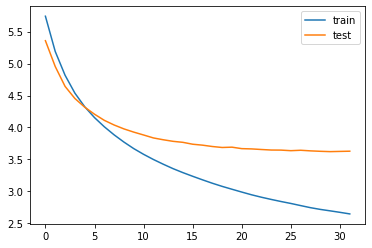

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. 인퍼런스 모델 구현하기

#### 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

#### 인코더 모델과 디코더 모델을 분리해서 설계

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 어텐션 메커니즘을 사용하는 출력층을 설계

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 8. 모델 테스트하기

#### 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수
#### 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

#### 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : woman named emily solved case matched thief stole sparkling water also theft victim tinder first man named drew told emily found full sparkling water later emily matched raymond lost sparkling water leaving unattended 
실제 요약 : woman matches with both thief and his victim on tinder solves case 
예측 요약 :  woman caught stealing phone from bengaluru police


원문 : germany deported tunisian man allegedly served former al qaeda chief osama bin laden bodyguard man identified sami living germany since argued deportation claiming could tortured sent back tunisia received nearly month welfare payments germany 
실제 요약 : osama bin laden bodyguard deported from germany 
예측 요약 :  man who called osama bin laden jailed for yrs


원문 : uber hired nelson chai chief financial officer filling role vacant since chai former merrill lynch cfo recently ceo insurance firm warranty group uber ceo dara khosrowshahi earlier said finding new cfo taking longer would liked 
실제 요약 : uber fills cfo position that was 

예측 요약 :  need to increase in sports in years gadkari


원문 : nobel memorial prize economics among awards alfred nobel established sweden central bank marking th anniversary made donation nobel foundation establish prize economic sciences memory alfred nobel laureate selected royal swedish academy sciences 
실제 요약 : nobel prize founder did not the prize in economics 
예측 요약 :  nobel prize nobel prize at nobel prize awards


원문 : prankster known interrupted live bbc broadcast sex noises using loudspeaker bbc political reporting live outside houses parliament london prankster played sounds however completely ignored sounds kept straight face 
실제 요약 : prankster interrupts bbc live broadcast with sex noises 
예측 요약 :  ex cia agent apologises for sex with hitler


원문 : icc charged ex sri lanka captain sanath jayasuriya two counts breaching anti corruption code charges relate failure refusal cooperate investigation obstructing delaying investigation including tampering destroying relevant documen

예측 요약 :  feel actor should be taught to sing in wood film director


원문 : rohit sharma shikhar dhawan scored respectively india defeated pakistan asia cup first encounter months team last faced june champions trophy final pakistan runs group toppers india face bangladesh first super four stage match friday 
실제 요약 : india beat pak by wickets in their first encounter in months 
예측 요약 :  dhawan dhawan to miss pakistan in pakistan


원문 : senegal born singer announced launch cryptocurrency called available sale two weeks part venture singer plans complete crypto based city acres land located near capital city senegal land gifted president 
실제 요약 : singer to launch cryptocurrency called 
예측 요약 :  singer unveils sale of cryptocurrency


원문 : delhi high court friday refused restrain journalist arnab goswami news channel republic tv airing news congress mp shashi tharoor wife sunanda pushkar death court also asked goswami republic tv send advance notice tharoor views airing news connection push

## 9. 추출적 요약해보기

#### 데이터 다운로드하기

In [48]:
import requests
from summa.summarizer import summarize

#### 매트릭스 시놉시스를 다운로드

In [49]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

#### 출력결과 일부만 저장해보기

In [50]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

#### summarize 사용하여 원문의 0.005%만을 출력해도록 설정

In [51]:
print('headlines:')
print(summarize(text, ratio=0.005))

headlines:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


####  split 인자의 값을 True로 하기

In [52]:
print('headlines:')
print(summarize(text, ratio=0.005, split=True))

headlines:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


#### 단어를 50개만 선택

In [53]:
print('headlines:')
print(summarize(text, words=50))

headlines:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## 회고

- Text의 적절한 최대 최소 길이와 Summary의 적절한 최대 최소 길이 설정하기에서의 에러해결
    - and를 사용하여 해결할 수 있었고, lambda 함수를 사용하는 부분은 2번으로 나누어서 해결하였다.
    
- 정수인코딩 시에 단어의 크기를 정해주는 과정의 판단
    - 적절한 크기를 두기 위해서  Encoder에서는 8회 미만으로, Decoder에서는 5회 미만으로 지정하여 이에 맞는 단어의 크기를 지정하여 정수인코딩 해주었다.

## 루브릭
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
    - 3, 4 과정에서 확인할 수 있다.
    
- 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
    - 과정 6의 마지막에서 확인할 수 있다.

- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.
    - PASS